<center><span style="color:black; font-size:25px; font-family:'Times New Roman'"><b>Retail Sales Analysis and Prediction: Insights from Customer Behavior</b></span></center>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from mlxtend.frequent_patterns import apriori, association_rules
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Online Retail Sales Analysis - Exploring Sales Patterns and Customer Behaviors

This project analyzes sales transactions in an online retail store to uncover patterns in sales, identify frequently purchased items, and understand customer purchasing behaviors.

### Objectives:
- Identify products that are frequently purchased together.
- Analyze seasonal trends and purchasing behavior.
- Build predictive models to forecast sales.

Dataset: The dataset contains transactions from 2009-2011. We are analyzing data from two years: 2009 and 2010.


## Data Loading and Initial Inspection

In this section, we are loading the data from two sheets of an Excel file. The sheets represent transactions for the years 2009 and 2010. We concatenate the data into a single DataFrame for easier analysis.

Below, we will inspect the first few rows of the concatenated data and check its structure.

In [43]:
# Read data from the Excel file "data.xlsx"
# Load the data into two different DataFrames
df1 = pd.read_excel("data.xlsx", sheet_name='Year 2009-2010')
df2 = pd.read_excel("data.xlsx", sheet_name='Year 2010-2011')

In [3]:
# Concatenate the two DataFrames (df1 and df2) along the rows to create a single DataFrame
df = pd.concat([df1, df2])

# Display the first few rows of the concatenated DataFrame
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
# Display a summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


<center><span style="color:black; font-size:25px; font-family:Calibri">Pre-processing</span></center>

## Pre-processing

In this step, we perform the initial data cleaning:
1. **Counting Duplicate Rows**: First, we check how many duplicate rows are present in the DataFrame.
2. **Dropping Duplicates**: We then remove these duplicates to ensure we work with clean data.
3. **Checking for Null Values**: We check for any missing values in the dataset.


In [5]:
# Count and display the number of duplicate rows in the DataFrame
count_duplicates = df.duplicated().sum()
count_duplicates

34335

In [6]:
# Droping the duplicate rows from the DataFrame
df = df.drop_duplicates()
df.shape

(1033036, 8)

In [7]:
# Check for the null values
df.isnull().sum()

Invoice             0
StockCode           0
Description      4275
Quantity            0
InvoiceDate         0
Price               0
Customer ID    235151
Country             0
dtype: int64

## Data Cleaning

1. **Remove Rows with Null Description**: 
   - We drop any rows where the `Description` column is null, ensuring that only valid entries are retained.
2. **Handling Cancelled Transactions**: 
   - We check for transactions where the `Invoice` contains the letter "C", which indicates cancellations. These rows are removed from the dataset.


In [8]:
# Drop the rows for whom Description is null
df.dropna(subset=['Description'],inplace=True)
df.shape

(1028761, 8)

In [9]:
# Check for cancelled transactions
df['Invoice'] = df['Invoice'].astype(str)
df_refunded = df[df['Invoice'].str.contains('C')]
df_refunded.shape

(19104, 8)

In [10]:
# Remove the rows for cancelled transactions
df = df[~df["Invoice"].str.contains("C", na = False)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1009657 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1009657 non-null  object 
 1   StockCode    1009657 non-null  object 
 2   Description  1009657 non-null  object 
 3   Quantity     1009657 non-null  int64  
 4   InvoiceDate  1009657 non-null  object 
 5   Price        1009657 non-null  float64
 6   Customer ID  779495 non-null   float64
 7   Country      1009657 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 69.3+ MB


## Pre-processing

In this step, we perform the following tasks:

1. **Check for Rows with Zero Price**: We inspect rows where the `Price` column is 0, as these rows are likely invalid.
2. **Drop Rows with Zero Price**: We drop the rows where `Price` is 0, as they are not meaningful for analysis.


In [11]:
# Check for rows that have Price as 0
df_ZeroPrice = df[df['Price'] == 0]
df_ZeroPrice.shape

(1739, 8)

In [12]:
# Drop the rows where Price as 0
df.drop(df[df['Price'] == 0.0].index, inplace=True)
df.shape

(1007918, 8)

## Data Cleaning - StockCode Reshaping

In this part of data cleaning:
1. **Reshape Stock Code**: We ensure that the `StockCode` column contains unique 6-digit stock codes. If the `StockCode` starts with a digit, we retain only those entries.
2. **Remove Invalid Stock Codes**: Any entries where the `StockCode` does not match the criteria are removed from the DataFrame.
3. **Check Unique Values**: We print the number of unique `StockCode` and `Description` values to check for consistency in the data.


In [13]:
# Reshape the Stock Code to have be unique 6 digit
df['StockCode'] = df['StockCode'].astype(str)
df['StartsWithNumber'] = df['StockCode'].str.contains('^\d', regex=True)
df = df[df['StartsWithNumber']]
df= df.drop(columns=['StartsWithNumber'])
df.shape

(1003214, 8)

In [14]:
# Print the number of unique stock codes and descriptions in the DataFrame
print(df.StockCode.nunique())
print(df.Description.nunique())

4878
5360


## Removing Invalid Descriptions and StockCodes

We perform further cleaning:
1. **Remove Rows with Multiple StockCodes for a Description**: If a `Description` is associated with more than one `StockCode`, we remove such rows.
2. **Remove Rows with Multiple Descriptions for a StockCode**: If a `StockCode` is associated with more than one `Description`, we also remove these rows.

Finally, we print the number of unique `StockCode` and `Description` values again to confirm that the cleaning was successful.


In [15]:
# Remove rows from the original DataFrame where the Description is associated with more than one StockCode
df_product = df[["Description","StockCode"]].drop_duplicates()
df_product = df_product.groupby(["Description"]).agg({"StockCode":"count"}).reset_index()
df_product.sort_values("StockCode", ascending=False).head()
df_product.rename(columns={'StockCode':'StockCode_Count'},inplace=True)
df_product = df_product[df_product["StockCode_Count"]>1]
df = df[~df["Description"].isin(df_product["Description"])]
print(df.StockCode.nunique())
print(df.Description.nunique())

4506
5137


In [16]:
# Remove rows from the original DataFrame where the StockCode is associated with more than one Description
df_product = df[["Description","StockCode"]].drop_duplicates()
df_product = df_product.groupby(["StockCode"]).agg({"Description":"count"}).reset_index()
df_product.rename(columns={'Description':'Description_Count'},inplace=True)
df_product = df_product.sort_values("Description_Count", ascending=False)
df_product = df_product[df_product["Description_Count"] > 1] 
df = df[~df["StockCode"].isin(df_product["StockCode"])]
print(df.StockCode.nunique())
print(df.Description.nunique())

3928
3928


## Summary

After cleaning the dataset, we generate a statistical summary to review key metrics, such as the count, mean, and standard deviation, for each numerical column.

In [17]:
# Display a statistical summary of the DataFrame
df.describe()

,Quantity,Price,Customer ID
count,716262.000000,716262.000000,551501.000000
mean,11.280975,3.303334,15354.218946
std,149.703214,5.010856,1686.920012
min,1.000000,0.030000,12346.000000
25%,1.000000,1.250000,14029.000000
50%,3.000000,2.100000,15296.000000
75%,12.000000,3.950000,16814.000000
max,80995.000000,1157.150000,18287.000000


## Top 10 Most Preferred Products

This bar chart shows the top 10 most preferred products based on their count in the dataset. The products with the highest purchase counts are displayed, with the number of purchases annotated above each bar.

This chart helps identify the most popular products in the online retail store.

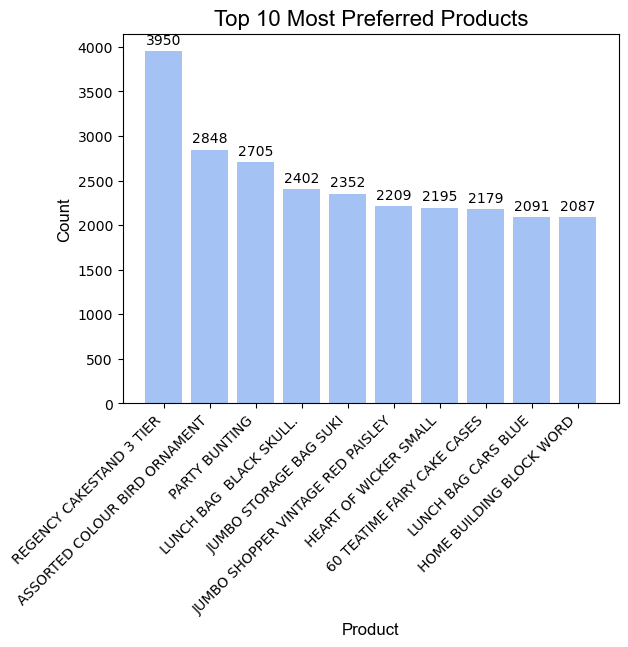

In [18]:
# Create bar chart for most preferred products
most_preferred_products = df['Description'].value_counts()[:10]
fig, ax = plt.subplots()
bars = ax.bar(most_preferred_products.index, most_preferred_products.values, color='#a4c2f4')
for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom')
ax.set_title('Top 10 Most Preferred Products', fontsize=16, fontfamily='Arial')
ax.set_xlabel('Product', fontsize=12, fontfamily='Arial')
ax.set_ylabel('Count', fontsize=12, fontfamily='Arial')
plt.xticks(rotation=45, ha='right')
plt.tight_layout(pad=3)
plt.show()

<span style="color:black; font-size:16px;">The above graph visualizes the most frequently preferred products, allowing for quick identification of which products are the most popular.</span>

## Customer Base by Countries

This bar chart shows the distribution of the customer base across different countries. Each country is uniquely colored, and the count of customers from each country is displayed. The chart helps to visualize the customer distribution and identify the countries with the highest customer base.

The countries included are:
- United Kingdom
- EIRE
- Germany
- France
- Netherlands
- Spain
- Switzerland
- Belgium
- Portugal
- Australia


<Figure size 1200x600 with 0 Axes>

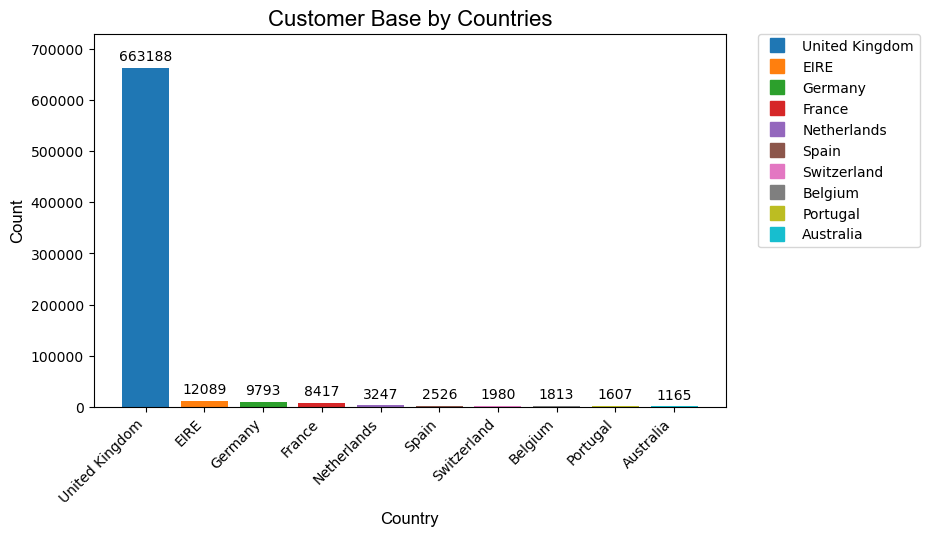

In [19]:
# Create bar chart for customer base by country
countries = df['Country'].value_counts()[:10]
colors = plt.cm.get_cmap('tab10', len(countries))
plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(countries.index, countries.values, color=[colors(i) for i in range(len(countries))])
for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom')
ax.set_title('Customer Base by Countries', fontsize=16, fontfamily='Arial')
ax.set_xlabel('Country', fontsize=12, fontfamily='Arial')
ax.set_ylabel('Count', fontsize=12, fontfamily='Arial')
plt.xticks(rotation=45, ha='right')
legend_labels = countries.index
legend_colors = [colors(i) for i in range(len(countries))]
patches = [plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=legend_colors[i], 
            label="{:s}".format(legend_labels[i]))[0]  for i in range(len(legend_labels))]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(pad=3)
ax.set_ylim(0, max(countries.values) * 1.1)
plt.show()

<span style="color:black; font-size:16px;">This above bar chart shows the top 10 countries by customer count, with each country uniquely colored and annotated for clarity. This visualization is important for understanding the distribution of the customer base geographically.</span>

## Customer Orders Throughout the Day

The histogram illustrates the distribution of customer orders throughout the day, grouped by hourly bins. It shows the number of orders placed during each hour of the day, helping to identify peak buying times for customers.

This visualization is useful for understanding when customers are most active in placing orders.


In [20]:
# Extract the hour from the 'InvoiceDate'
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['time'] = df['InvoiceDate'].dt.strftime('%H')

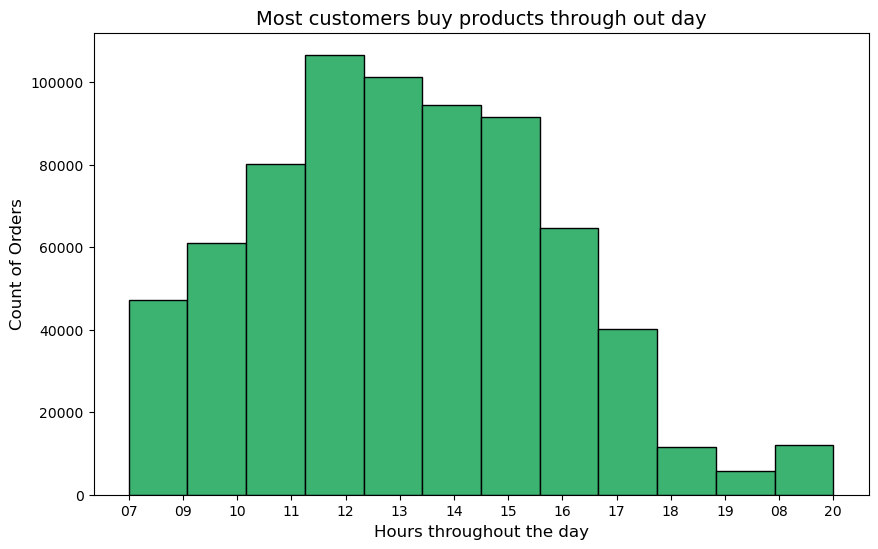

In [21]:
# Create histogram for Orders Count throughout the day
plt.figure(figsize=(10, 6))
plt.hist(df['time'], bins=12, color='mediumseagreen', edgecolor='black')
plt.xlabel('Hours throughout the day', fontsize=12)
plt.ylabel('Count of Orders', fontsize=12)
plt.title('Most customers buy products through out day', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

<span style="color:black; font-size:16px;">This histogram illustrates the distribution of customer orders throughout the day, showing the count of orders across 12 hourly bins. It is important for identifying peak buying times.</span>

<center><span style="color:black; font-size:25px; font-family:Calibri">Time Series Analysis</span></center>

## Time Series Analysis

In this step, we are performing time-series analysis on the sales data:
1. **Setting Invoice Date as Index**: The `InvoiceDate` is set as the index of the DataFrame for time-based operations.
2. **Create a New Column `TotalPrice`**: We calculate the total price for each transaction by multiplying the `Quantity` with the `Price` of each item.


In [22]:
# Reset index of DataFrame
df.set_index('InvoiceDate', inplace=True)

In [23]:
# Create new column TotalPrice
df["TotalPrice"] = df["Quantity"] * df["Price"]

## Time Series Analysis - Plotting Total Price by Week

In this part, we plot the **TotalPrice** on a weekly basis, using a weekly resampling technique to observe trends. This will help us identify patterns, including spikes during certain months.


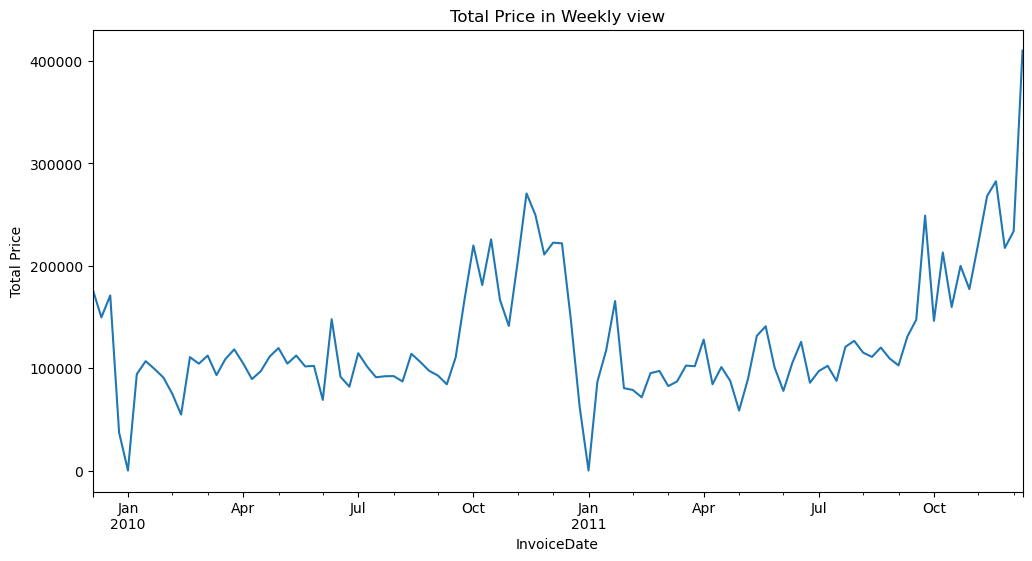

In [24]:
# Plot TotalPrice by Weekly
weekly_data = df['TotalPrice'].resample('W').sum()
weekly_data.plot(figsize=(12, 6))
plt.ylabel('Total Price')
plt.title('Total Price in Weekly view')
plt.show()

<span style="color:black; font-size:16px;">
This visualization depicts the weekly time-series view of our dataset, with the Total Price calculated as Quantity multiplied by Price. We’ve used InvoiceDate as our index, and the data spans from January 2010 to January 2012.
We see fluctuations and seasonal patterns over the period, including notable spikes during the end-of-year holiday seasons and dips during slower sales months..</span>

## Train-Test Split and SARIMAX Model

1. **Splitting Data into Train and Test Sets**: We split the dataset into a training set (up to July 2011) and a test set (August 2011 onwards) to evaluate the forecasting model.
2. **Fitting the SARIMAX Model**: The SARIMAX model is trained using the training dataset, where both seasonal and non-seasonal components are defined.
3. **SARIMAX Model Summary**: The model's summary is displayed, showing coefficients and other important statistical metrics.


In [25]:
# Split the data into train and test
train = weekly_data[:'2011-07-31']
test = weekly_data['2011-08-01':]

In [26]:
# Fit the SARIMAX model
model = sm.tsa.statespace.SARIMAX(train, 
                                  order=(1, 1, 1), 
                                  seasonal_order=(1, 1, 1, 52),
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         TotalPrice   No. Observations:                   87
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                   0.000
Date:                            Thu, 01 Aug 2024   AIC                             10.000
Time:                                    20:20:12   BIC                                nan
Sample:                                12-06-2009   HQIC                               nan
                                     - 07-31-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0022         -0        inf      0.000      -0.002      -0.002
ma.L1         -0.5676         -0   

## Forecasting Future Values with SARIMAX

We use the trained SARIMAX model to forecast future values. The forecast is made for 12 weeks, with confidence intervals plotted to visualize uncertainty.

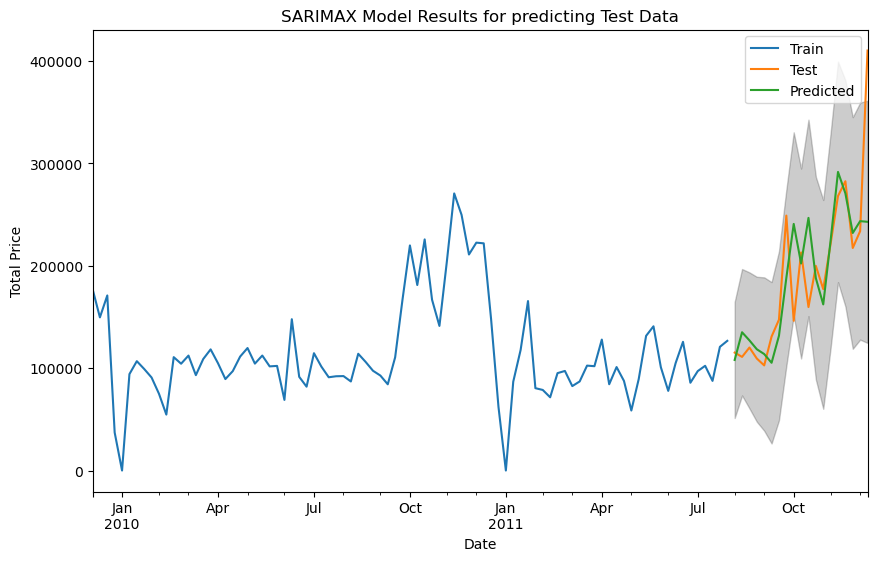

In [27]:
# Test and validate the model
pred = results.get_forecast(steps=len(test))
pred_ci = pred.conf_int()
ax = train.plot(label='Train', figsize=(10, 6))
test.plot(ax=ax, label='Test')
pred.predicted_mean.plot(ax=ax, label='Predicted')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Total Price')
plt.title('SARIMAX Model Results for predicting Test Data')
plt.legend()
plt.show()

<span style="color:black; font-size:16px;">This graph represents the results of our SARIMAX model used to predict total sales over time. The model was trained on historical sales data from January 2010 to August 2011, with predictions made for the subsequent period. Here’s a detailed interpretation of the chart:
Model Accuracy:
The close alignment between the predicted and actual test data suggests that the SARIMAX model is accurately capturing the sales patterns. 
This accuracy is crucial for making reliable forecasts and business decisions.
Sales Trends:
The model effectively identifies seasonal trends, such as increased sales during certain months, which can be leveraged for inventory management and promotional activities.
Forecast Reliability:
The confidence intervals provide insight into the forecast’s reliability, helping business stakeholders understand potential risks and uncertainties in the predictions.</span>

## Compare Predicted vs. Actual Values

This graph compares the **forecasted values** against the actual data, showing the model’s accuracy in predicting future total prices.
The shaded region represents the confidence interval, indicating the uncertainty of the forecast.


In [28]:
# Compare the values
predicted_mean = pred.predicted_mean
forecast_df = pd.DataFrame({
    'Test': test,
    'Forecast': predicted_mean,
    'Lower CI': pred_ci.iloc[:, 0],
    'Upper CI': pred_ci.iloc[:, 1]
})
forecast_df

                 Test       Forecast       Lower CI       Upper CI
2011-08-07  115216.76  108024.021187   51281.841120  164766.201255
2011-08-14  111023.26  135095.645628   73324.872678  196866.418579
2011-08-21  120150.70  127149.383151   60703.989873  193594.776430
2011-08-28  109412.51  118482.653286   47670.614586  189294.691987
2011-09-04  102694.93  113799.513286   38874.888644  188724.137928
2011-09-11  130879.51  105267.103286   26444.175590  184090.030982
2011-09-18  147372.18  131627.553286   49090.237584  214164.868988
2011-09-25  249071.48  188200.833286  102109.236506  274292.430066
2011-10-02  146266.46  240927.673286  151422.826552  330432.520020
2011-10-09  213056.69  202248.283286  109455.653505  295040.913067
2011-10-16  159739.47  246829.103286  150861.261305  342796.945267
2011-10-23  199927.14  187888.343286   88847.032474  286929.654097
2011-10-30  177261.84  162299.923286   60277.691395  264322.155177
2011-11-06  221613.79  224823.123286  119904.629431  329741.61

## Model Accuracy - Root Mean Squared Error (RMSE)

To evaluate the model's performance, we calculate the **Root Mean Squared Error (RMSE)** for the forecasted values. This gives us an understanding of the model's prediction accuracy.



In [29]:
# Calculate RSME for predicted value
mse = mean_squared_error(test, predicted_mean)
rmse = np.sqrt(mse)
print(f'The Root Mean Squared Error of our forecasts is {rmse:.2f}')

The Root Mean Squared Error of our forecasts is 52087.56


In [30]:
# Train the model for whole dataset
model_f = sm.tsa.statespace.SARIMAX(weekly_data, 
                                  order=(1, 1, 1), 
                                  seasonal_order=(1, 1, 1, 52),
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)
results_f = model_f.fit()
results_f.summary()

                                     SARIMAX Results                                      
Dep. Variable:                         TotalPrice   No. Observations:                  106
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                   0.000
Date:                            Thu, 01 Aug 2024   AIC                             10.000
Time:                                    20:20:13   BIC                                nan
Sample:                                12-06-2009   HQIC                               nan
                                     - 12-11-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3854         -0        inf      0.000      -0.385      -0.385
ma.L1         -0.3804         -0   

## Forecasting Future Values for 12 Weeks

After training the SARIMAX model, we use it to forecast the next 12 weeks of total price. The forecast includes:
1. **Historical Data**: The original data, which is plotted in blue.
2. **Forecast**: The predicted values, plotted in orange.
3. **Confidence Interval**: The shaded area representing the uncertainty in the forecast.

This forecast provides insights into expected future sales, helping the business make informed decisions.


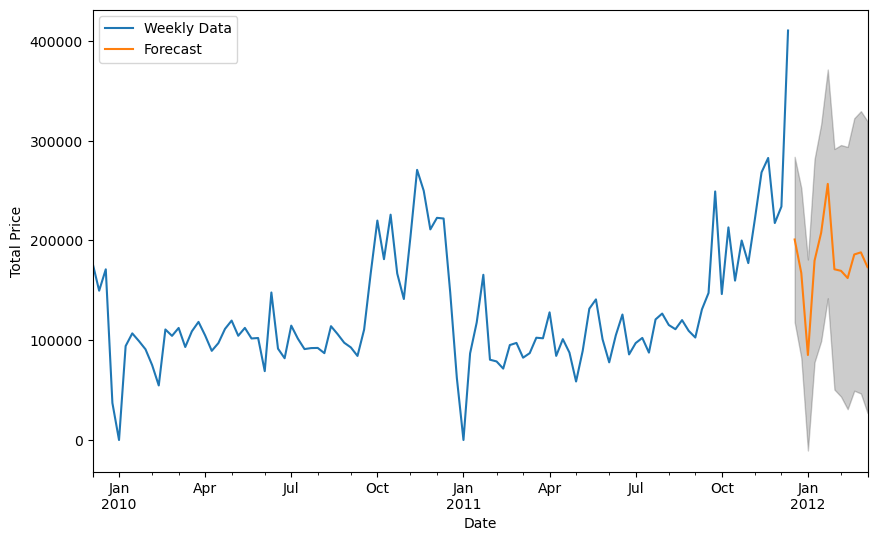

In [31]:
# Forecast the value for 12 weeks
pred_f = results_f.get_forecast(steps=12)
pred_ci_f = pred_f.conf_int()
ax = weekly_data.plot(label='Historical Data', figsize=(10, 6))
pred_f.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci_f.index,
                pred_ci_f.iloc[:, 0],
                pred_ci_f.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Total Price')
plt.title('Forecasted Price for next 12 weeks')
plt.legend()
plt.show()

<span style="color:black; font-size:16px;">The forecasted graph displays the actual weekly sales data and the SARIMAX model's forecast for future sales. 
The historical data shows a clear pattern of seasonal fluctuations, with notable peaks around the holiday season each year. 
The forecast suggests that sales will remain within a similar range to past years, but with some potential for significant deviation due to external factors not captured in the model.</span>


<center><span style="color:black; font-size:25px; font-family:Calibri">Market Basket Analysis</span></center>

## Market Basket Analysis

In this section, we perform a Market Basket Analysis to identify frequently bought products together. We follow these steps:

1. **Filter the Data for the UK Dataset**: We focus on the data from the **United Kingdom** to analyze the shopping patterns of UK customers specifically.

   **Reason for Focus**: 
   - **Largest Customer Base**: As observed in the previous graph, the **UK** has the largest customer base, making it the most relevant market for this analysis.
   - Analyzing data from the **UK** allows for more accurate insights into local customer preferences. By focusing on this region, we can capture the most meaningful purchasing behaviors, which are beneficial for businesses operating locally.

2. **Group Data by 'Invoice' and 'Description'**: We group the data by `Invoice` and `Description`, aggregating the quantities to create a basket of items bought together. Quantities are then converted to binary values (0 or 1) where `1` indicates the presence of an item in a transaction.

3. **Apply the Apriori Algorithm**: The **Apriori** algorithm is applied to the basket data to find frequent itemsets, which reveal combinations of products that are often purchased together. We set a minimum support threshold of `0.015` to filter out infrequent itemsets.

4. **Display the Frequent Itemsets**: We display the resulting frequent itemsets, showing the products that are commonly purchased together and their associated support values.


In [32]:
# Filter the DataFrame for UK Dataset
df_uk = df[df["Country"] == "United Kingdom"]
df_uk.shape

(663188, 9)

In [33]:
# Group the data by 'Invoice' and 'Description' and convert quantities to binary values
basket = df_uk.groupby(['Invoice', "Description"])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)

In [34]:
# Apply the Apriori algorithm to the basket data to find frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.015, use_colnames=True)
# Display the resulting frequent itemsets
frequent_itemsets

,support,itemsets
0,0.016991,(12 PENCIL SMALL TUBE WOODLAND)
1,0.022588,(12 PENCILS SMALL TUBE SKULL)
2,0.015820,(12 PENCILS TALL TUBE SKULLS)
3,0.019846,(3 HEARTS HANGING DECORATION RUSTIC)
4,0.017819,(3 HOOK PHOTO SHELF ANTIQUE WHITE)
...,...,...
334,0.023444,"(PAPER CHAIN KIT 50'S CHRISTMAS , PAPER CHAIN ..."
335,0.016734,"(PARTY BUNTING, REGENCY CAKESTAND 3 TIER)"
336,0.017847,"(PINK CREAM FELT CRAFT TRINKET BOX , PINK BLUE..."
337,0.018190,"(WOODLAND CHARLOTTE BAG, STRAWBERRY CHARLOTTE ..."


## Frequent Itemsets Analysis

1. **Sorting Frequent Itemsets**: In this step, we sort the frequent itemsets based on their support values in descending order. This helps identify the most commonly bought item combinations.
   
2. **Distribution of Support Values**: A histogram is plotted to show the distribution of the support values of frequent itemsets. The histogram helps us understand the frequency of itemsets across different support thresholds.

    - **Interpretation**: The shape of the distribution gives insights into how many itemsets have low support compared to those with high support.


In [35]:
# Sort the frequent itemsets by their support values in descending order
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

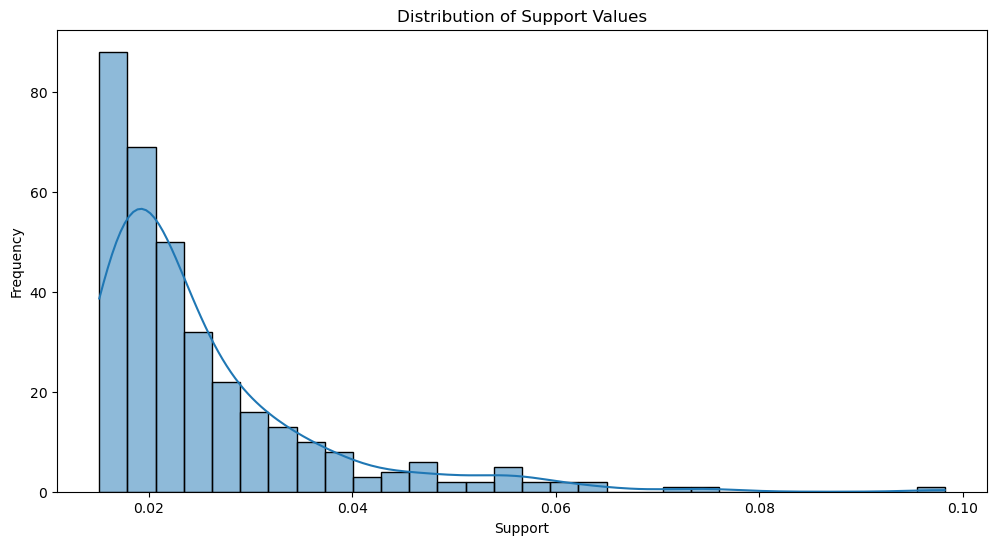

In [36]:
# Plot a histogram of frequent itemsets, with KDE to show distribution's shape
plt.figure(figsize=(12, 6))
sns.histplot(frequent_itemsets['support'], bins=30, kde=True)
plt.title('Distribution of Support Values')
plt.xlabel('Support')
plt.ylabel('Frequency')
plt.show()

<span style="color:black; font-size:16px;">The histogram of support values for frequent itemsets reveals that most itemsets have low support, with the majority clustered between 0.01 and 0.03. This indicates that while there are many item combinations, only a few appear frequently in transactions. The distribution is right-skewed, suggesting a small number of itemsets have relatively high support and contribute significantly to sales volume.</span>

## Top 10 Frequent Itemsets

A **pie chart** is generated to display the **Top 10 itemsets by support**. The chart shows the proportions of the most frequent itemsets, highlighting which product combinations are the most popular among customers.

- The **larger slices** indicate itemsets with higher support, such as **Regency Cakestand 3 Tier** and **Home Building Block Word**.


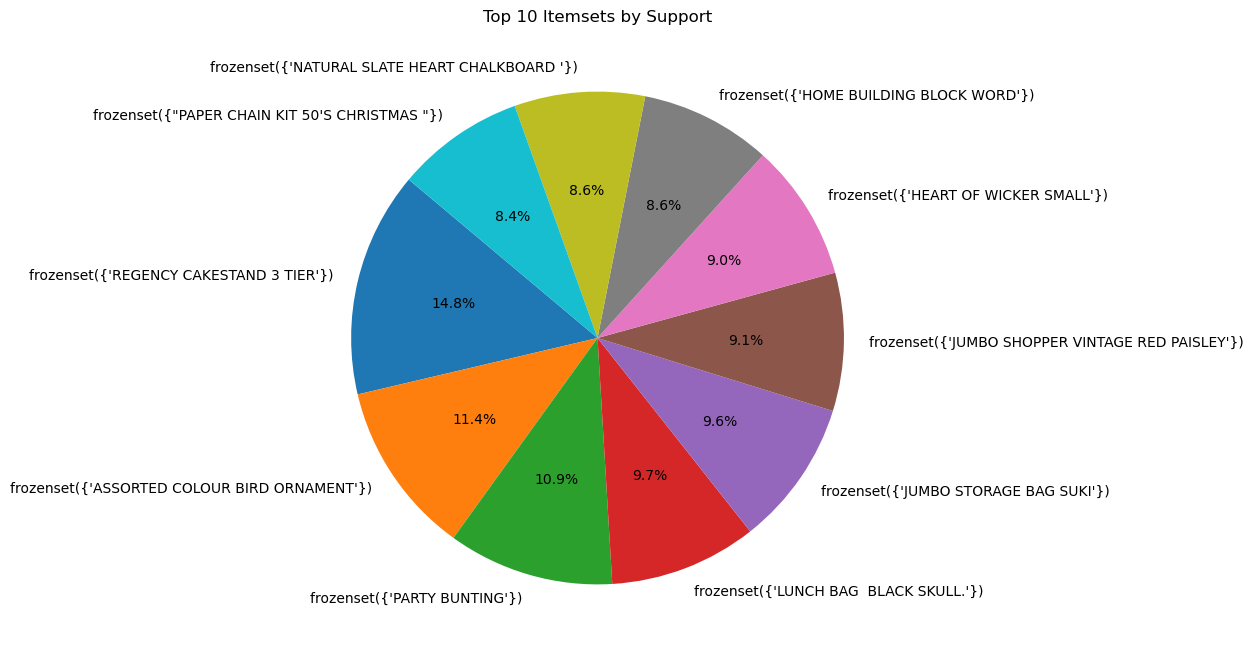

In [37]:
# Plot a pie chart of the top 10 itemsets
top_itemsets = frequent_itemsets.head(10)
plt.figure(figsize=(10, 8))
plt.pie(top_itemsets['support'], labels=top_itemsets['itemsets'].astype(str), autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Itemsets by Support')
plt.show()

<span style="color:black; font-size:16px;">Dominant Itemsets: The itemset (REGENCY CAKESTAND 3 TIER) has the largest share of transactions at 14.8%, making it the most frequently purchased item among the top 10.
High Support Items: Notable itemsets include ASSORTED COLOUR BIRD ORNAMENT at 11.4%, PARTY BUNTING at 10.9%, and JUMBO STORAGE BAG SUKI at 9.6%, indicating their popularity and importance to inventory.
Mid-Level Support Items: Itemsets like LUNCH BAG BLACK SKULL at 9.7%, JUMBO SHOPPER VINTAGE RED PAISLEY at 9.1%, and HEART OF WICKER SMALL at 9.0% are moderately popular and contribute significantly to sales.
Lower Support Items: Items such as NATURAL SLATE HEART CHALKBOARD, HOME BUILDING BLOCK WORD, and PAPER CHAIN KIT 50'S CHRISTMAS have support around 8.4% to 8.6%, still important to the product lineup despite lower frequencies.</span>

## Dominant Itemsets and Association Rules

The **Regency Cakestand 3 Tier** itemset has the largest share of transactions, accounting for 14.8%. Other notable itemsets with high support include **Assorted Colour Bird Ornament** and **Party Bunting**.

We now move on to generate **association rules** using the **lift metric**. These rules will reveal relationships between items that frequently appear together in transactions, and can provide valuable insights into customer purchasing behavior.

The association rules help us understand:
- What products are often bought together.
- How certain items complement each other in the market.


In [38]:
# Generate association rules from the frequent itemsets using the "lift" metric
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
# Display the generated association rules
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(HEART OF WICKER LARGE),(HEART OF WICKER SMALL),0.055084,0.059910,0.028156,0.511146,8.531845,0.024856,1.923047,0.934255
1,(HEART OF WICKER SMALL),(HEART OF WICKER LARGE),0.059910,0.055084,0.028156,0.469971,8.531845,0.024856,1.782763,0.939051
2,(JUMBO SHOPPER VINTAGE RED PAISLEY),(JUMBO STORAGE BAG SUKI),0.060167,0.063623,0.025101,0.417181,6.557116,0.021273,1.606635,0.901750
3,(JUMBO STORAGE BAG SUKI),(JUMBO SHOPPER VINTAGE RED PAISLEY),0.063623,0.060167,0.025101,0.394524,6.557116,0.021273,1.552222,0.905077
4,(LUNCH BAG CARS BLUE),(LUNCH BAG BLACK SKULL.),0.054285,0.064308,0.024273,0.447133,6.952999,0.020782,1.692436,0.905322
...,...,...,...,...,...,...,...,...,...,...
65,(PACK OF 60 DINOSAUR CAKE CASES),(PACK OF 60 PINK PAISLEY CAKE CASES),0.033439,0.051315,0.015249,0.456020,8.886690,0.013533,1.743972,0.918175
66,(HAND OVER THE CHOCOLATE SIGN ),(COOK WITH WINE METAL SIGN ),0.040721,0.038436,0.015192,0.373072,9.706235,0.013627,1.533769,0.935049
67,(COOK WITH WINE METAL SIGN ),(HAND OVER THE CHOCOLATE SIGN ),0.038436,0.040721,0.015192,0.395245,9.706235,0.013627,1.586228,0.932828
68,(JUMBO STORAGE BAG SUKI),(JUMBO BAG TOYS ),0.063623,0.028699,0.015135,0.237882,8.288928,0.013309,1.274475,0.939105


## Least Frequent Itemsets

We also analyze the **least frequent itemsets** by plotting a **bar chart**. This chart displays the itemsets with the lowest support values. While these itemsets may not appear frequently, they could still offer valuable insights into niche market preferences.

- These itemsets might represent **seasonal products** or items with less overall demand but important for specialized customer needs.


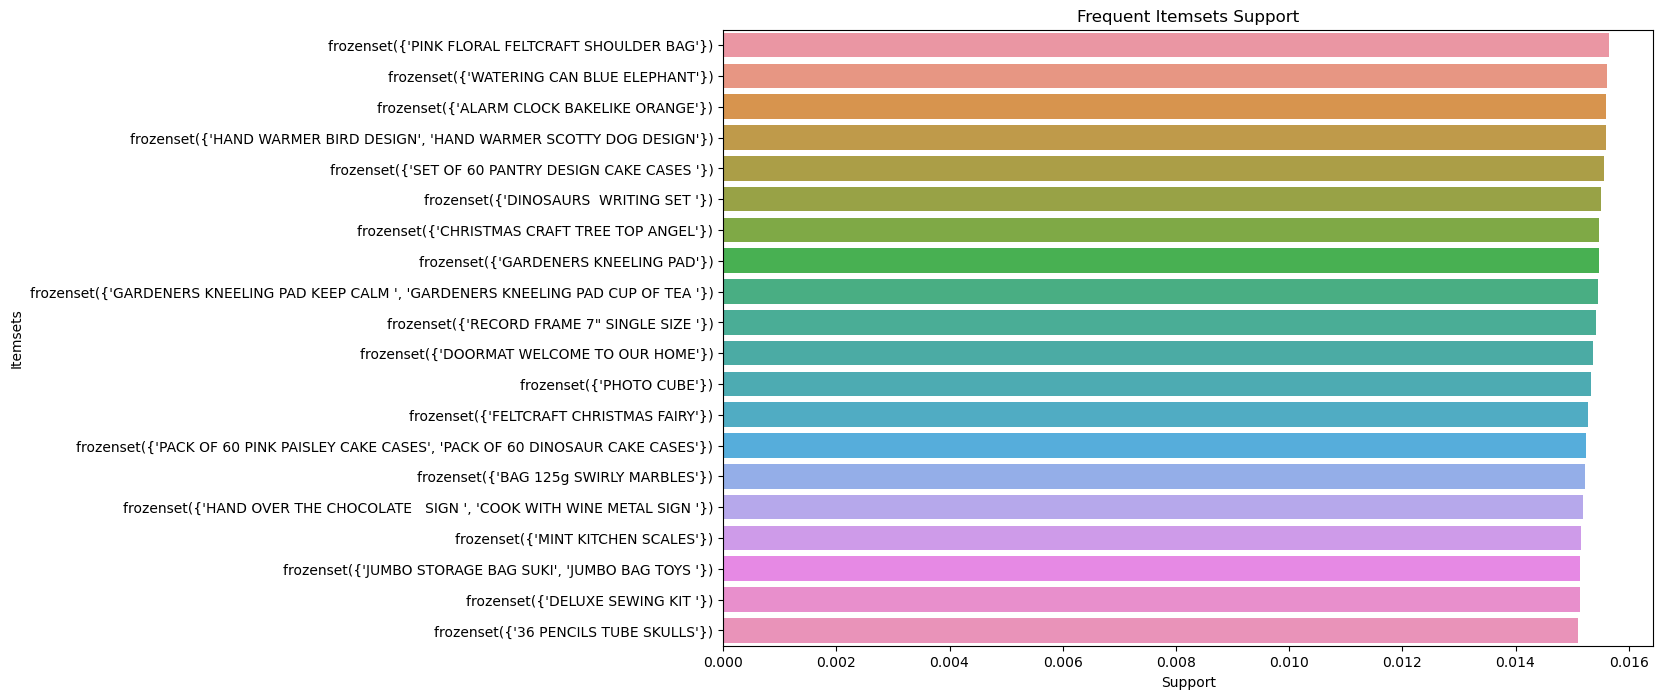

In [39]:
# Plot a bar chart for least frequent itemsets
plt.figure(figsize=(12, 8))
sns.barplot(x='support', y='itemsets', data=frequent_itemsets.tail(10))
plt.title('Frequent Itemsets Support')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()

## Confidence vs Lift

A **scatter plot** is used to compare **confidence** against **lift** from the association rules. The plot helps visualize the relationships between the strength of the association (lift) and the likelihood of the products being purchased together (confidence).

- **Lift** measures how much more likely two products are to be bought together than by random chance.
- **Confidence** measures the proportion of transactions where the consequent item is purchased, given that the antecedent item is purchased.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


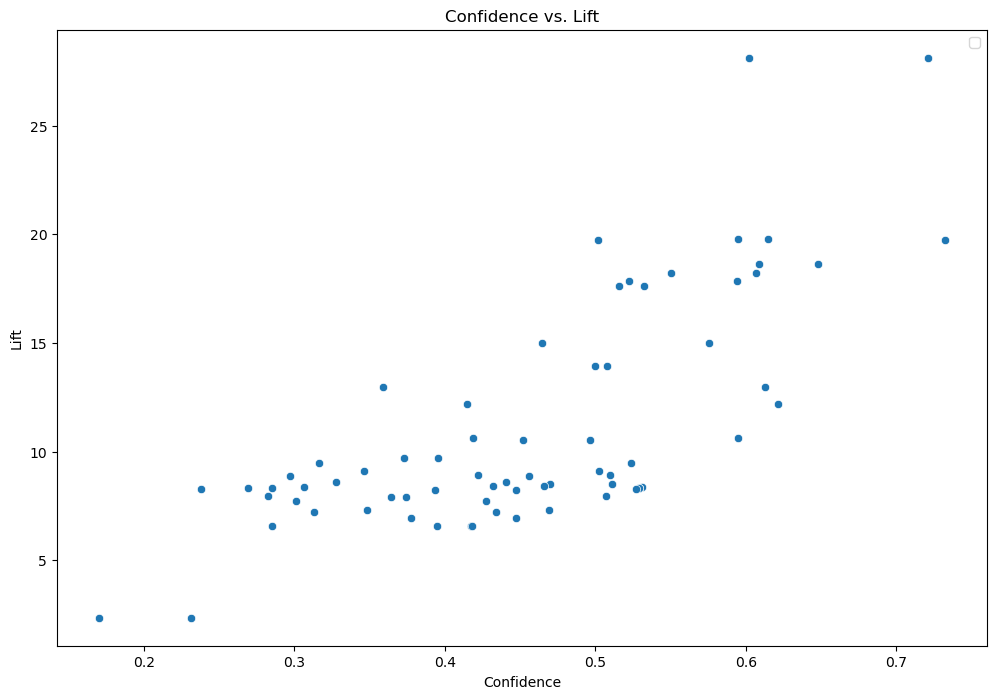

In [42]:
# Plot a scatter plot of 'confidence' vs. 'lift' from the association rules
plt.figure(figsize=(12, 8))
sns.scatterplot(x='confidence', y='lift', data=rules, palette='viridis')
plt.title('Confidence vs. Lift')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.legend()
plt.show()

<span style="color:black; font-size:16px;">The plot shows a positive correlation between confidence and lift, suggesting that as the confidence of a rule increases, its lift also tends to increase.
This trend indicates that rules with high confidence also tend to be more significant (higher lift), meaning they are better than random chance and show strong associations between items.</span>
